In [73]:
from autoscalingsim import simulator
from datetime import datetime

starting_datetime_str = "2020-09-17T10:00:00"
starting_time = datetime.strptime(starting_datetime_str, '%Y-%m-%dT%H:%M:%S')
simulation_step_ms = 10
time_to_simulate_days = 0.005
config_dir = "experiments/test"
results_dir = None

simulator = simulator.Simulator(simulation_step_ms,
                                starting_time,
                                time_to_simulate_days)

simulator.add_simulation(config_dir,
                         results_dir)

simulator.start_simulation()

  9%|▉         | 3800/43199 [00:00<00:03, 10690.63it/s]

[2020-09-19 11:37:10.297408] Left to simulate: 7 min or 42199 steps
[2020-09-19 11:37:10.327279] Left to simulate: 6 min or 41199 steps
[2020-09-19 11:37:10.404989] Left to simulate: 6 min or 40199 steps


 13%|█▎        | 5439/43199 [00:00<00:04, 9134.23it/s] 

[2020-09-19 11:37:10.525161] Left to simulate: 6 min or 39199 steps
[2020-09-19 11:37:10.651380] Left to simulate: 6 min or 38199 steps


 16%|█▋        | 7091/43199 [00:00<00:04, 8642.72it/s]

[2020-09-19 11:37:10.770761] Left to simulate: 6 min or 37199 steps
[2020-09-19 11:37:10.893607] Left to simulate: 6 min or 36199 steps


 22%|██▏       | 9551/43199 [00:01<00:04, 8231.14it/s]

[2020-09-19 11:37:11.024523] Left to simulate: 5 min or 35199 steps
[2020-09-19 11:37:11.150639] Left to simulate: 5 min or 34199 steps
[2020-09-19 11:37:11.274013] Left to simulate: 5 min or 33199 steps


 28%|██▊       | 11973/43199 [00:01<00:03, 8028.01it/s]

[2020-09-19 11:37:11.398967] Left to simulate: 5 min or 32199 steps
[2020-09-19 11:37:11.525072] Left to simulate: 5 min or 31199 steps


 33%|███▎      | 14381/43199 [00:01<00:03, 7951.03it/s]

[2020-09-19 11:37:11.656507] Left to simulate: 5 min or 30199 steps
[2020-09-19 11:37:11.783511] Left to simulate: 4 min or 29199 steps
[2020-09-19 11:37:11.900160] Left to simulate: 4 min or 28199 steps


 41%|████      | 17656/43199 [00:02<00:03, 8113.01it/s]

[2020-09-19 11:37:12.025167] Left to simulate: 4 min or 27199 steps
[2020-09-19 11:37:12.149558] Left to simulate: 4 min or 26199 steps


 45%|████▍     | 19276/43199 [00:02<00:02, 8063.98it/s]

[2020-09-19 11:37:12.271033] Left to simulate: 4 min or 25199 steps
[2020-09-19 11:37:12.396565] Left to simulate: 4 min or 24199 steps


 48%|████▊     | 20913/43199 [00:02<00:02, 7973.25it/s]

[2020-09-19 11:37:12.519731] Left to simulate: 3 min or 23199 steps
[2020-09-19 11:37:12.652623] Left to simulate: 3 min or 22199 steps


 54%|█████▍    | 23368/43199 [00:02<00:02, 8120.58it/s]

[2020-09-19 11:37:12.773982] Left to simulate: 3 min or 21199 steps
[2020-09-19 11:37:12.893985] Left to simulate: 3 min or 20199 steps
[2020-09-19 11:37:13.015840] Left to simulate: 3 min or 19199 steps


 58%|█████▊    | 25025/43199 [00:02<00:02, 8212.20it/s]

[2020-09-19 11:37:13.134782] Left to simulate: 3 min or 18199 steps


 64%|██████▎   | 27432/43199 [00:03<00:02, 7699.86it/s]

[2020-09-19 11:37:13.272161] Left to simulate: 2 min or 17199 steps
[2020-09-19 11:37:13.404817] Left to simulate: 2 min or 16199 steps


 69%|██████▉   | 29828/43199 [00:03<00:01, 7896.20it/s]

[2020-09-19 11:37:13.537706] Left to simulate: 2 min or 15199 steps
[2020-09-19 11:37:13.668270] Left to simulate: 2 min or 14199 steps


 73%|███████▎  | 31485/43199 [00:03<00:01, 7883.50it/s]

[2020-09-19 11:37:13.784780] Left to simulate: 2 min or 13199 steps
[2020-09-19 11:37:13.905252] Left to simulate: 2 min or 12199 steps


 77%|███████▋  | 33059/43199 [00:04<00:01, 7139.97it/s]

[2020-09-19 11:37:14.040112] Left to simulate: 1 min or 11199 steps
[2020-09-19 11:37:14.197564] Left to simulate: 1 min or 10199 steps


 81%|████████▏ | 35139/43199 [00:04<00:01, 6467.50it/s]

[2020-09-19 11:37:14.364815] Left to simulate: 1 min or 9199 steps
[2020-09-19 11:37:14.525621] Left to simulate: 1 min or 8199 steps


 87%|████████▋ | 37712/43199 [00:04<00:00, 6225.53it/s]

[2020-09-19 11:37:14.685938] Left to simulate: 1 min or 7199 steps
[2020-09-19 11:37:14.851113] Left to simulate: 1 min or 6199 steps


 90%|█████████ | 38960/43199 [00:04<00:00, 6197.49it/s]

[2020-09-19 11:37:15.013334] Left to simulate: 0 min or 5199 steps
[2020-09-19 11:37:15.173332] Left to simulate: 0 min or 4199 steps


 96%|█████████▌| 41538/43199 [00:05<00:00, 6342.97it/s]

[2020-09-19 11:37:15.340467] Left to simulate: 0 min or 3199 steps
[2020-09-19 11:37:15.492937] Left to simulate: 0 min or 2199 steps


43200it [00:05, 7698.19it/s]                           

[2020-09-19 11:37:15.646885] Left to simulate: 0 min or 1199 steps
[2020-09-19 11:37:15.782914] Left to simulate: 0 min or 199 steps


In [142]:
callable(np.mean)

True

In [172]:
import sys
import os
import numpy as np
import math
from autoscalingsim.simulation.simulation import Simulation
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

CDF_FILENAME = 'cdf_response_times.png'
RESP_TIMES_HIST_FILENAME = 'hist_response_times.png'
FULFILLED_FAILED_BARS_FILENAME = 'bars_fulfilled_failed.png'

TOTAL_REQS_BARS_FILENAME = 'bars_total_gen_reqs.png'
BUF_WAIT_TIME_HIST_FILENAME = 'hist_buf_waiting_time.png'
REQ_TIMES_DISTR_BARS_FILENAME = 'bars_req_time_distribution_by_cat.png'

MAX_PLOTS_CNT_ROW = 4

class AnalysisFramework:
    """
    Combines the functionality to build the figures based on the simulation
    results. The following figures are supported:
        - Autoscaling quality evaluation category:
            + CDF of the response times, all the request types on the same plot
            + Histogram of the response times, separately for each request type
            + Barchart of fulfilled requests vs dropped, a bar for each request type
            > utilization?
        - Autoscaling behaviour characterization category:
            > Line graph (x axis - time) of the desired/current node count,
              separately for each node type
            > Line graph (x axis - time) of the generated requests count,
              all the request types on the same plot
            + Barchart of the overall amount of generated requests by type
            + Histogram of the waiting times in the service buffers,
              separately for each buffer (idea - to locate the bottleneck service)
            + Barchart of the processing vs waiting vs network time for the fulfilled requests,
              a bar for each request type
    """
    def __init__(self,
                 simulation_step_ms,
                 figures_dir = None):
        
        self.simulation_step_ms = simulation_step_ms
        self.figures_dir = figures_dir
        
    def build_figures(self,
                      simulation = None,
                      results_dir = None,
                      figures_dir = None):
        # TODO: figure settings from config file?
        # TODO: get results from the results_dir, also need to add storing into it
        if simulation is None and results_dir is None:
            sys.exit('Neither simulation nor results directory is provided, cannot build figures.')
        
        figures_dir_in_use = self.figures_dir
        
        if not figures_dir is None:
            figures_dir_in_use = figures_dir
            
        # Getting the data into the unified representation for processing
        # either from the simulation or from the results_dir
        response_times_per_request_type = {}
        workload_ts_per_request_type = {}
        buffer_times_by_request = {}
        network_times_by_request = {}
        if not simulation is None:      
            workload_ts_per_request_type = simulation.workload_model.workload
            response_times_per_request_type = simulation.application_model.response_times_by_request
            buffer_times_by_request = simulation.application_model.buffer_times_by_request
            network_times_by_request = simulation.application_model.network_times_by_request
        
        # Building figures with the internal functions
        self._resp_times_cdf(response_times_per_request_type,
                             figures_dir = figures_dir_in_use)
        
        self._resp_times_histogram(response_times_per_request_type,
                                   3 * self.simulation_step_ms,
                                   figures_dir = figures_dir_in_use)
        
        self._fulfilled_dropped_barchart(response_times_per_request_type,
                                         workload_ts_per_request_type,
                                         figures_dir = figures_dir_in_use)
        
        self._generated_requests_by_type_barchart(workload_ts_per_request_type,
                                                  figures_dir = figures_dir_in_use)
        
        self._waiting_service_buffers_histogram(buffer_times_by_request,
                                                bins_size_ms = 3 * self.simulation_step_ms,
                                                figures_dir = figures_dir_in_use)
        
        self._distribution_of_reqs_times_barchart(response_times_per_request_type,
                                                  buffer_times_by_request,
                                                  network_times_by_request,
                                                  figures_dir = figures_dir_in_use)
    
    def _resp_times_cdf(self,
                        response_times_per_request_type,
                        figures_dir = None):
        """
        Builds CDF of the requests by the response times, separate line for
        each request type.
        """
        
        max_response_time = max([max(response_times_of_req) for response_times_of_req in response_times_per_request_type.values()])
        cdf_xlim = max_response_time + 1 * self.simulation_step_ms + 1
        x_axis = range(0, cdf_xlim, self.simulation_step_ms)
        
        cdfs_per_req_type = {}
        for req_type, response_times in response_times_per_request_type.items():
            reqs_count_binned = [0] * len(x_axis)
            
            for response_time in response_times:
                reqs_count_binned[response_time // self.simulation_step_ms] += 1
            
            cdfs_per_req_type[req_type] = np.cumsum(reqs_count_binned) / sum(reqs_count_binned)
        
        for req_type, cdf_vals in cdfs_per_req_type.items():
            plt.plot(x_axis, cdf_vals, label = req_type)
        
        percentiles = [0.99, 0.95, 0.90, 0.80, 0.50]
        font = {'color':  'black',
                'weight': 'normal',
                'size': 8}
        for percentile in percentiles:
            plt.hlines(percentile, min(x_axis), max(x_axis),
                       colors='k', linestyles='dashed', lw = 0.5)
            plt.text(0, percentile + 0.001,
                     "{}th percentile".format(int(percentile * 100)),
                     fontdict = font)
        
        plt.xlabel('Response time, ms')
        plt.legend(loc = "lower right")
        
        if not figures_dir is None:
            figure_path = os.path.join(figures_dir, CDF_FILENAME)
            plt.savefig(figure_path)
        else:
            plt.title('CDF of requests by response time')
            plt.show()
            
    def _resp_times_histogram(self,
                              response_times_per_request_type,
                              bins_size_ms = 10,
                              figures_dir = None):
        
        """
        Builds histogram of requests by the response time.
        """
        max_response_time = max([max(response_times_of_req) for response_times_of_req in response_times_per_request_type.values()])
        bins_cnt = math.ceil(max_response_time / bins_size_ms)
        
        plots_count = len(response_times_per_request_type)
        rows_cnt = 1
        cols_cnt = plots_count
        if plots_count > MAX_PLOTS_CNT_ROW:
            rows_cnt = math.ceil(plots_count / MAX_PLOTS_CNT_ROW)
        
        fig, axs = plt.subplots(rows_cnt, cols_cnt,
                                sharey = True, tight_layout = True)
        
        # Ref: https://stackoverflow.com/questions/6963035/pyplot-axes-labels-for-subplots/36542971#36542971
        fig.add_subplot(111, frameon = False)
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        
        i = 0
        for req_type, response_times in response_times_per_request_type.items():
            axs_adapted = axs
            
            if cols_cnt * rows_cnt > 1:
                axs_adapted = axs[i]
                i += 1
                
            axs_adapted.hist(response_times,
                             bins = bins_cnt)
            axs_adapted.title.set_text(req_type)
            

        plt.xlabel('Response time, ms')
        plt.ylabel('Completed requests')
        
        if not figures_dir is None:
            figure_path = os.path.join(figures_dir, RESP_TIMES_HIST_FILENAME)
            plt.savefig(figure_path)
        else:
            plt.suptitle('Distribution of requests by response time', y = 1.05)
            plt.show()
            
    def _fulfilled_dropped_barchart(self,
                                    response_times_per_request_type,
                                    workload_ts_per_request_type,
                                    bar_width = 0.15,
                                    figures_dir = None):
        """
        Builds a barchart of fulfilled requests vs dropped,
        a bar for each request type.
        """
        
        req_types = list(workload_ts_per_request_type.keys())
        succeeded_reqs = []
        failed_reqs = []
        max_req_cnt = 0
        for req_type, workload_timeline in workload_ts_per_request_type.items():
            responses_cnt = 0
            if req_type in response_times_per_request_type:
                responses_cnt = len(response_times_per_request_type[req_type])
            
            succeeded_reqs.append(responses_cnt)
            
            requests_cnt = 0
            for _, cnt in workload_timeline:
                requests_cnt += cnt
                
            failed_reqs_cnt = requests_cnt - responses_cnt
            failed_reqs.append(failed_reqs_cnt)
            
            max_req_cnt = max([max_req_cnt, requests_cnt])
                
        plt.bar(req_types, succeeded_reqs,
                bar_width, label='Fulfilled')
        plt.bar(req_types, failed_reqs,
                bar_width, bottom = succeeded_reqs, label='Failed')

        plt.ylabel('Requests count')
        plt.ylim(top = int(max_req_cnt * 1.05))
        plt.legend()
        
        if not figures_dir is None:
            figure_path = os.path.join(figures_dir, FULFILLED_FAILED_BARS_FILENAME)
            plt.savefig(figure_path)
        else:
            plt.suptitle('Fulfilled and failed requests')
            plt.show()
    
    def _generated_requests_by_type_barchart(self,
                                             workload_ts_per_request_type,
                                             bar_width = 0.15,
                                             figures_dir = None):
        """
        Barchart of the overall amount of generated requests by type.
        """
        
        req_types = list(workload_ts_per_request_type.keys())
        reqs_cnts = {}
        max_req_cnt = 0
        for req_type, workload_timeline in workload_ts_per_request_type.items():
            
            requests_cnt = 0
            for _, cnt in workload_timeline:
                requests_cnt += cnt
                
            reqs_cnts[req_type] = requests_cnt
            
            max_req_cnt = max([max_req_cnt, requests_cnt])
        
        plt.bar(list(reqs_cnts.keys()), list(reqs_cnts.values()),
                bar_width)

        plt.ylabel('Requests count')
        plt.ylim(top = int(max_req_cnt * 1.05))
        
        if not figures_dir is None:
            figure_path = os.path.join(figures_dir, TOTAL_REQS_BARS_FILENAME)
            plt.savefig(figure_path)
        else:
            plt.suptitle('Total generated requests by type')
            plt.show()
    
    def _waiting_service_buffers_histogram(self,
                                           buffer_times_by_request,
                                           bins_size_ms = 10,
                                           figures_dir = None):
        """
        Builds a set of histograms for the waiting times in buffers.
        """
        
        outer_rows_cnt = len(buffer_times_by_request)
        outer_cols_cnt = 1
        fig = plt.figure()#figsize=(10, 8))
        fig.add_subplot(111, frameon = False)
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        outer = gridspec.GridSpec(outer_rows_cnt, outer_cols_cnt,
                                  wspace=0.2, hspace=1.0)
        
        font = {'color':  'black',
                'weight': 'bold',
                'size': 12}
        
        i = 0
        for req_type, buffers_waiting_times_raw in buffer_times_by_request.items():
            
            ax_out = plt.Subplot(fig, outer[i])
            ax_out.set_title('Request type {}'.format(req_type),
                             y = 1.2,
                             fontdict = font)
            
            ax_out.set_xlabel('Time spent waiting in the buffer, ms')
            ax_out.set_ylabel('Waiting requests')
            ax_out.xaxis.labelpad = 25
            ax_out.yaxis.labelpad = 15
            ax_out.set_xticks([])
            #ax_out.set_yticks([])
            
            fig.add_subplot(ax_out)
            
            buffers_waiting_times = {}
            for buffer_waiting_time_raw in buffers_waiting_times_raw:
                service_name = list(buffer_waiting_time_raw.keys())[0]
                buffer_waiting_time_for_service = list(buffer_waiting_time_raw.values())[0]
                
                if service_name in buffers_waiting_times:
                    buffers_waiting_times[service_name].append(buffer_waiting_time_for_service)
                else:
                    buffers_waiting_times[service_name] = [buffer_waiting_time_for_service]
            
            max_waiting_time = max([max(sublist) for sublist in list(buffers_waiting_times.values())])
            bins_cnt = math.ceil(max_waiting_time / bins_size_ms)
            
            plots_count = len(buffers_waiting_times)
            rows_cnt = 1
            cols_cnt = plots_count
            if plots_count > MAX_PLOTS_CNT_ROW:
                rows_cnt = math.ceil(plots_count / MAX_PLOTS_CNT_ROW)
                
            # Plotting for req type
            inner = gridspec.GridSpecFromSubplotSpec(rows_cnt,
                                                     cols_cnt,
                                                     subplot_spec = outer[i],
                                                     wspace = 0.5,
                                                     hspace = 0.1)
            
            j = 0
            for service_name, service_buffer_waiting_times in buffers_waiting_times.items():
                ax = plt.Subplot(fig, inner[j], sharey = ax_out)
                
                ax.hist(service_buffer_waiting_times,
                        bins = bins_cnt)
                ax.title.set_text('Buffers of the {} service'.format(service_name))
                
                
                if not ax.is_last_row():
                    plt.setp(ax.get_xticklabels(), visible=False)

                plt.setp(ax.get_yticklabels(), visible=False)
                
                fig.add_subplot(ax)              
                    
                j += 1
            
            i += 1
        
        if not figures_dir is None:
            figure_path = os.path.join(figures_dir, BUF_WAIT_TIME_HIST_FILENAME)
            plt.savefig(figure_path)
        else:
            plt.suptitle('Distribution of requests by buffer waiting time', y = 1.05)
            plt.show()
            
    def _distribution_of_reqs_times_barchart(self,
                                             response_times_per_request_type,
                                             buffer_times_by_request,
                                             network_times_by_request,
                                             aggregation_fn = np.mean,
                                             bar_width = 0.15,
                                             figures_dir = None):
        """
        Barchart of the processing vs waiting vs network time
        for the fulfilled requests, a bar for each request type
        """
        if not callable(aggregation_fn):
            sys.exit('The aggregation function object is not callable.')
        
        aggregated_processing_time_per_req_type = []
        aggregated_buf_waiting_time_per_req_type = []
        aggregated_network_time_per_req_type = []
        
        req_types = list(response_times_per_request_type.keys())
        for req_type in req_types:
            
            req_type_response_times = response_times_per_request_type[req_type]
            
            req_type_network_times = [0.0]
            if req_type in network_times_by_request:
                req_type_network_times = network_times_by_request[req_type]
            aggregated_network_time_per_req_type.append(aggregation_fn(req_type_network_times))
                
            req_type_buf_waiting_times = [0.0]
            if req_type in buffer_times_by_request:
                req_type_buf_waiting_times = [list(buf_wait_time.values())[0] for buf_wait_time in buffer_times_by_request[req_type]]
            aggregated_buf_waiting_time_per_req_type.append(aggregation_fn(req_type_buf_waiting_times))
            
            agg_proc_time = aggregation_fn(req_type_response_times) - (aggregated_buf_waiting_time_per_req_type[-1] + aggregated_network_time_per_req_type[-1])
            aggregated_processing_time_per_req_type.append(agg_proc_time)
            
        plt.bar(req_types, aggregated_processing_time_per_req_type,
                bar_width, label='Processing')
        plt.bar(req_types, aggregated_network_time_per_req_type,
                bar_width, bottom = aggregated_processing_time_per_req_type,
                label='Transferring')
        
        plt.bar(req_types, aggregated_buf_waiting_time_per_req_type,
                bar_width, bottom = np.array(aggregated_processing_time_per_req_type) \
                                    + np.array(aggregated_network_time_per_req_type),
                label='Waiting')
        
        plt.ylabel('Duration, ms')
        plt.legend(loc = 'upper right', bbox_to_anchor=(0.9, -0.1), ncol = 3)
        
        if not figures_dir is None:
            figure_path = os.path.join(figures_dir, REQ_TIMES_DISTR_BARS_FILENAME)
            plt.savefig(figure_path)
        else:
            plt.suptitle('Distribution of the request time in the application,\
            \naggregated with the {} function'.format(aggregation_fn.__name__))
            plt.show()
        

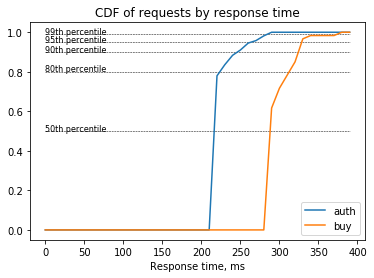

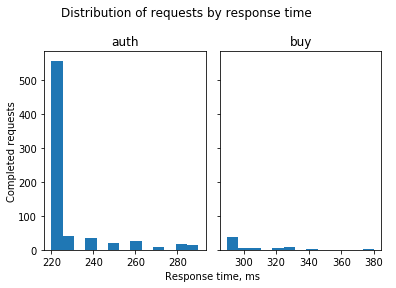

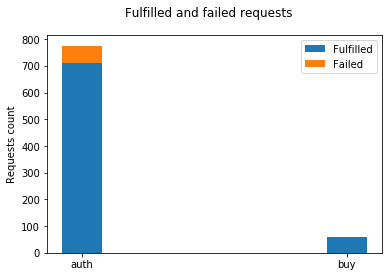

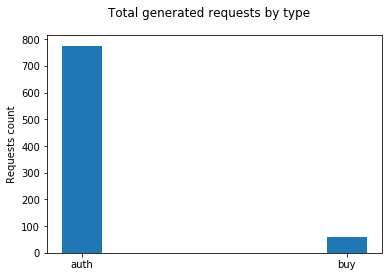

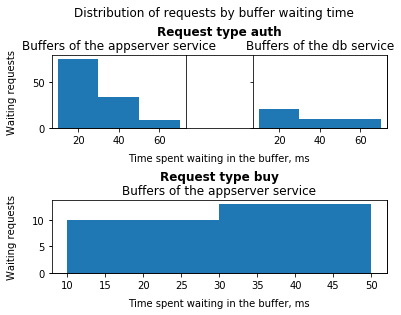

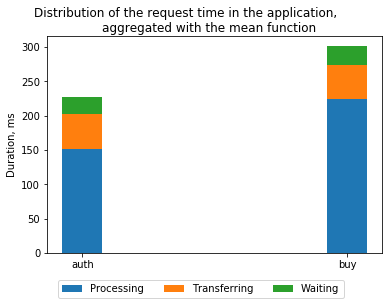

In [173]:
analysis_framework = AnalysisFramework(simulation_step_ms)
analysis_framework.build_figures(simulator.simulations["test"])

In [156]:
np.sum([[1,2], [3,4]])

10